# **Import lib**

In [7]:
from keras import models
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, UpSampling2D, Reshape, Permute, Dropout, Flatten, Dense
from keras.optimizers import Adam
import os, numpy as np, matplotlib.pyplot as plt, json, cv2

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

import random, shutil

import time
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix

# **1) Chuẩn hóa dữ liệu**

Dataset btxrd-v2
- Giảm kích thước ảnh: scale = 0.5
- Chuẩn hóa ảnh thành hình vuông 2440x2440
- Cập nhật lại points

In [2]:
image_dir = "/kaggle/input/btxrd-data/BTXRD/BTXRD/images" 

# Biến lưu kích thước min & max
min_width, min_height = float('inf'), float('inf')
max_width, max_height = 0, 0

# Lặp qua tất cả ảnh
for file in os.listdir(image_dir):
    if file.endswith(('.png', '.jpg', '.jpeg')):
        img = cv2.imread(os.path.join(image_dir, file))
        h, w, _ = img.shape  # Lấy chiều cao & chiều rộng

        # Cập nhật kích thước nhỏ nhất
        min_width, min_height = min(min_width, w), min(min_height, h)

        # Cập nhật kích thước lớn nhất
        max_width, max_height = max(max_width, w), max(max_height, h)

print(f"Kích thước nhỏ nhất: {min_width} x {min_height}")
print(f"Kích thước lớn nhất: {max_width} x {max_height}")

Kích thước nhỏ nhất: 153 x 311
Kích thước lớn nhất: 3594 x 4881


In [29]:
from tqdm import tqdm

image_dir = "/kaggle/input/btxrd-data/BTXRD/BTXRD/images"
annotation_dir = "/kaggle/input/btxrd-data/BTXRD/BTXRD/Annotations"

output_dir = "/kaggle/working/btxrd-data2"
output_image_dir = os.path.join(output_dir, "images")
output_anno_dir = os.path.join(output_dir, "Annotations")

os.makedirs(output_image_dir, exist_ok=True)
os.makedirs(output_anno_dir, exist_ok=True)

SCALE_FACTOR = 0.5
TARGET_SIZE = 2440

# Lấy danh sách file ảnh
image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Xử lý từng ảnh
for file in tqdm(image_files, desc="Processing images & annotations"):
    img_path = os.path.join(image_dir, file)
    anno_path = os.path.join(annotation_dir, file.rsplit('.', 1)[0] + '.json')

    img = cv2.imread(img_path)
    if img is None:
        print(f"⚠ Không thể đọc ảnh: {file}")
        continue

    orig_height, orig_width = img.shape[:2]

    # Resize ảnh
    new_width = int(orig_width * SCALE_FACTOR)
    new_height = int(orig_height * SCALE_FACTOR)
    img_resized = cv2.resize(img, (new_width, new_height))

    # Tính toán padding
    top = (TARGET_SIZE - new_height) // 2
    bottom = TARGET_SIZE - new_height - top
    left = (TARGET_SIZE - new_width) // 2
    right = TARGET_SIZE - new_width - left

    # Thêm padding vào ảnh
    padded_img = cv2.copyMakeBorder(img_resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    # Lưu ảnh sau khi scale & padding
    output_img_path = os.path.join(output_image_dir, file)
    cv2.imwrite(output_img_path, padded_img)

    # Nếu có annotation thì cập nhật và lưu lại
    if os.path.exists(anno_path):
        with open(anno_path, "r", encoding="utf-8") as f:
            annotation = json.load(f)

        # Cập nhật annotation (scale & padding)
        for shape in annotation["shapes"]:
            new_points = []
            for x, y in shape["points"]:
                # Scale tọa độ
                x = x * SCALE_FACTOR
                y = y * SCALE_FACTOR
                # Padding tọa độ
                x = x + left
                y = y + top
                new_points.append([x, y])

            shape["points"] = new_points  # Cập nhật điểm mới

        # Cập nhật kích thước ảnh trong annotation
        annotation["imageWidth"] = TARGET_SIZE
        annotation["imageHeight"] = TARGET_SIZE

        # Lưu annotation mới
        output_annotation_path = os.path.join(output_anno_dir, file.rsplit('.', 1)[0] + '.json')
        with open(output_annotation_path, "w", encoding="utf-8") as f:
            json.dump(annotation, f, indent=4)

print(f"\nHoàn thành! Ảnh và annotation đã lưu tại: {output_dir}")


Processing images & annotations: 100%|██████████| 3746/3746 [02:22<00:00, 26.35it/s]


Hoàn thành! Ảnh và annotation đã lưu tại: /kaggle/working/btxrd-data2


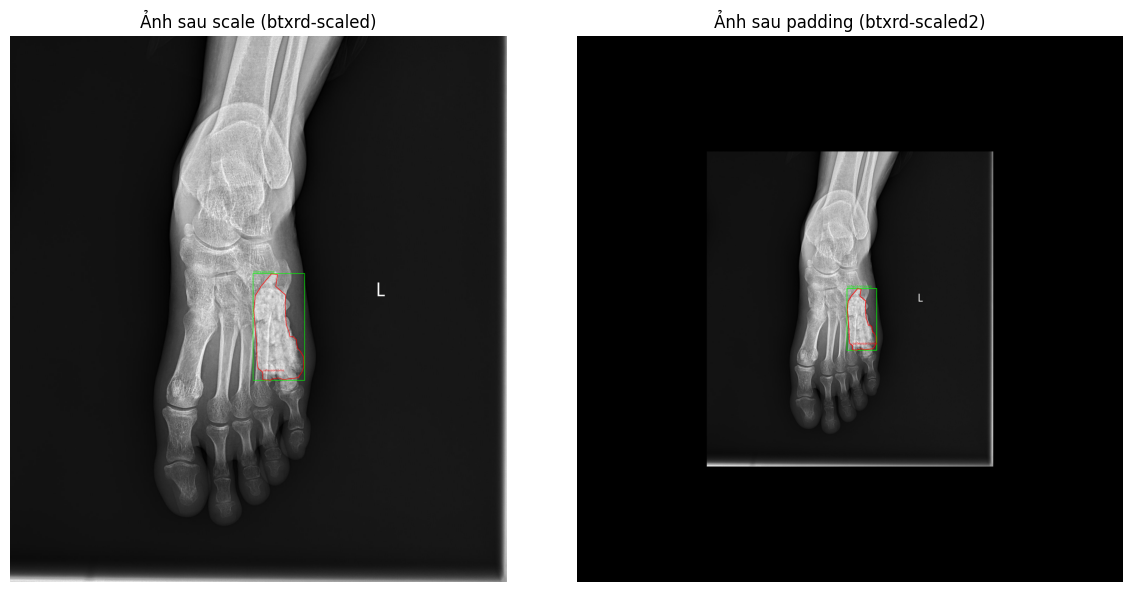

In [39]:
image_dirs = ["/kaggle/input/btxrd-data/BTXRD/BTXRD/images", "/kaggle/input/btxrd-v2/images"]
anno_dirs = ["/kaggle/input/btxrd-data/BTXRD/BTXRD/Annotations", "/kaggle/input/btxrd-v2/Annotations"]

# kiểm tra ảnh
image_name = "IMG000004.jpeg"

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
titles = ["Ảnh sau scale (btxrd-scaled)", "Ảnh sau padding (btxrd-scaled2)"]

for i in range(2):
    img_path = os.path.join(image_dirs[i], image_name)
    anno_path = os.path.join(anno_dirs[i], image_name.replace('.jpeg', '.json'))

    # Đọc ảnh
    img = cv2.imread(img_path)
    if img is None:
        print(f"⚠ Không tìm thấy ảnh: {img_path}")
        continue

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Chuyển ảnh về RGB

    # Đọc annotation nếu tồn tại
    if os.path.exists(anno_path):
        with open(anno_path, 'r', encoding='utf-8') as f:
            annotation = json.load(f)

        for shape in annotation["shapes"]:
            points = shape["points"]
            label = shape["label"]

            if shape["shape_type"] == "polygon":
                # Vẽ đường bao vùng ung thư (đa giác)
                pts = np.array(points, np.int32)
                pts = pts.reshape((-1, 1, 2))
                cv2.polylines(img, [pts], isClosed=True, color=(255, 0, 0), thickness=2)

                # Vẽ nhãn
                x, y = int(points[0][0]), int(points[0][1])
                cv2.putText(img, label, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1, cv2.LINE_AA)

            elif shape["shape_type"] == "rectangle":
                # Vẽ hình chữ nhật vùng ung thư
                x1, y1 = map(int, points[0])
                x2, y2 = map(int, points[1])
                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

                # Vẽ nhãn
                cv2.putText(img, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA)

    axes[i].imshow(img)
    axes[i].set_title(titles[i])
    axes[i].axis("off")

plt.tight_layout()
plt.show()


# **2) Chia tập dữ liệu**

Dataset btxrd-v3: tách btxrd-v2 thành 3 phần train, test, valid
   + train: 70%
   + valid: 20%
   + test: 10%

In [40]:
# Đường dẫn 
image_dir = "/kaggle/input/btxrd-v2/images""
annotation_dir = "/kaggle/input/btxrd-v2/Annotations""

output_base = "/kaggle/working/BTXRD_v3"
train_dir = os.path.join(output_base, "train")
test_dir = os.path.join(output_base, "test")
valid_dir = os.path.join(output_base, "valid")

In [41]:
# Tạo thư mục lưu ảnh mới
for folder in [train_dir, test_dir, valid_dir]:
    os.makedirs(os.path.join(folder, "images"), exist_ok=True)
    os.makedirs(os.path.join(folder, "Annotations"), exist_ok=True)

# Lấy danh sách ảnh
image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
random.shuffle(image_files)

# Tính số lượng ảnh cho mỗi tập
total = len(image_files)
train_split = int(0.7 * total)
test_split = int(0.2 * total)

# Chia danh sách ảnh
train_files = image_files[:train_split]
test_files = image_files[train_split:train_split + test_split]
valid_files = image_files[train_split + test_split:]

# Hàm di chuyển ảnh và annotation tương ứng
def move_files(files, dest_folder):
    for file in files:
        # Di chuyển ảnh
        shutil.copy(os.path.join(image_dir, file), os.path.join(dest_folder, "images", file))

        # Di chuyển file annotation nếu có
        annotation_file = file.replace(file.split('.')[-1], 'json')  # Đổi đuôi thành .json
        if os.path.exists(os.path.join(annotation_dir, annotation_file)):
            shutil.copy(os.path.join(annotation_dir, annotation_file), os.path.join(dest_folder, "Annotations", annotation_file))

# Di chuyển các tập dữ liệu
move_files(train_files, train_dir)
move_files(test_files, test_dir)
move_files(valid_files, valid_dir)

print(f"Đã chia {total} ảnh thành:")
print(f"- Train: {len(train_files)} ảnh")
print(f"- Test: {len(test_files)} ảnh")
print(f"- Valid: {len(valid_files)} ảnh")


Đã chia 3746 ảnh thành:
- Train: 2622 ảnh
- Test: 749 ảnh
- Valid: 375 ảnh


# **3) Xây dựng mô hình CNN**

In [1]:
n_classes = 2     # normal, tumor

In [5]:
# Đường dẫn dữ liệu
data_dir = '/kaggle/input/btxrd-v3/BTXRD_v3/'
train_images_dir = os.path.join(data_dir, "train", "images")
train_annotations_dir = os.path.join(data_dir, "train", "Annotations")
valid_images_dir = os.path.join(data_dir, "valid", "images")
valid_annotations_dir = os.path.join(data_dir, "valid", "Annotations")


In [39]:
INPUT_SHAPE = (2440, 2440, 3)
n_classes = 2

# eccoder
inputs = layers.Input(shape=INPUT_SHAPE)

# Block 1
x = layers.Conv2D(32, (3,3), strides=2, padding='same', activation='relu')(inputs)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
skip1 = x 

# Block 2
x = layers.Conv2D(64, (3,3), strides=2, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
skip2 = x  

# Block 3
x = layers.Conv2D(128, (3,3), strides=2, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
skip3 = x  

# Block 4
x = layers.Conv2D(256, (3,3), strides=2, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(256, (3,3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
skip4 = x  

# Bottleneck
x = layers.Conv2D(512, (3,3), strides=2, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(512, (3,3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)

In [40]:
# Decoder
# Block 5
x = layers.Conv2DTranspose(256, (3,3), strides=2, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Resizing(skip4.shape[1], skip4.shape[2])(x)
x = layers.Concatenate()([x, skip4])
x = layers.Conv2D(256, (3,3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)

# Block 4
x = layers.Conv2DTranspose(128, (3,3), strides=2, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Resizing(skip3.shape[1], skip3.shape[2])(x)
x = layers.Concatenate()([x, skip3])
x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)

# Block 3
x = layers.Conv2DTranspose(64, (3,3), strides=2, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Resizing(skip2.shape[1], skip2.shape[2])(x)
x = layers.Concatenate()([x, skip2])
x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)

# Block 2
x = layers.Conv2DTranspose(32, (3,3), strides=2, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Resizing(skip1.shape[1], skip1.shape[2])(x)
x = layers.Concatenate()([x, skip1])
x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)

# Block 1 (Khôi phục kích thước gốc)
x = layers.Conv2DTranspose(32, (3,3), strides=2, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)

outputs = layers.Conv2D(n_classes, (1,1), activation='softmax')(x)


In [42]:
# Compile mô hình
model = models.Model(inputs, outputs)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Hiển thị cấu trúc mô hình
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12            │ (None, 2440, 2440, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_122 (Conv2D)       │ (None, 1220, 1220, 32) │            896 │ input_layer_12[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_106   │ (None, 1220, 1220, 32) │            128 │ conv2d_122[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_123 (Conv2D)       │ (None, 1220, 1220, 32) │          9,248 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_107   │ (None, 1220, 1220, 32) │            128 │ conv2d_123[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_124 (Conv2D)       │ (None, 610, 610, 64)   │         18,496 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_108   │ (None, 610, 610, 64)   │            256 │ conv2d_124[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_125 (Conv2D)       │ (None, 610, 610, 64)   │         36,928 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_109   │ (None, 610, 610, 64)   │            256 │ conv2d_125[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_126 (Conv2D)       │ (None, 305, 305, 128)  │         73,856 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_110   │ (None, 305, 305, 128)  │            512 │ conv2d_126[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_127 (Conv2D)       │ (None, 305, 305, 128)  │        147,584 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_111   │ (None, 305, 305, 128)  │            512 │ conv2d_127[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_128 (Conv2D)       │ (None, 153, 153, 256)  │        295,168 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_112   │ (None, 153, 153, 256)  │          1,024 │ conv2d_128[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_129 (Conv2D)  

 Total params: 7,867,842 (30.01 MB)

 Trainable params: 7,861,890 (29.99 MB)

 Non-trainable params: 5,952 (23.25 KB)

# **Lưu & tải lại mô hình**

In [43]:
model.save("unet_model.h5")

In [44]:
model = load_model("unet_model.h5")

nhap

In [6]:
def load_data(images_dir, annotations_dir):
    images, labels = [], []
    image_files = [f for f in os.listdir(images_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    for img_file in image_files:
        img_path = os.path.join(images_dir, img_file)
        annotation_path = os.path.join(annotations_dir, os.path.splitext(img_file)[0] + '.json')

        # Đọc ảnh grayscale và resize
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (img_h, img_w))

        # Mặc định không có khối u (0)
        label = 0  
        if os.path.exists(annotation_path):
            with open(annotation_path, 'r') as f:
                annotation_data = json.load(f)
            if "shapes" in annotation_data and len(annotation_data["shapes"]) > 0:
                label = 1  # Có khối u

        images.append(img)
        labels.append(label)

    # Chuẩn hóa dữ liệu
    images = np.array(images, dtype=np.float32) / 255.0
    images = np.expand_dims(images, axis=-1)  # Thêm kênh để phù hợp với CNN
    labels = to_categorical(labels, num_classes=n_classes)

    return images, labels



In [7]:
x_train, y_train = load_data(train_images_dir, train_annotations_dir)
x_valid, y_valid = load_data(valid_images_dir, valid_annotations_dir)

In [8]:
# Kiểm tra số lượng mẫu trong tập train và validation
print(f"Số lượng ảnh trong tập train: {len(x_train)}")
print(f"Số lượng ảnh trong tập validation: {len(x_valid)}")

# Kiểm tra kích thước ảnh
print(f"Kích thước ảnh trong tập train: {x_train.shape}")
print(f"Kích thước ảnh trong tập validation: {x_valid.shape}")

# Kiểm tra nhãn
print(f"Số lượng nhãn (train): {np.bincount(np.argmax(y_train, axis=1))}")
print(f"Số lượng nhãn (validation): {np.bincount(np.argmax(y_valid, axis=1))}")


Số lượng ảnh trong tập train: 2622
Số lượng ảnh trong tập validation: 375
Kích thước ảnh trong tập train: (2622, 96, 96, 1)
Kích thước ảnh trong tập validation: (375, 96, 96, 1)
Số lượng nhãn (train): [1306 1316]
Số lượng nhãn (validation): [187 188]


In [9]:
# Định nghĩa CNN
input_image = Input(shape=(img_h, img_w, 1), name='Input')

x = Conv2D(64, (3, 3), padding='same', activation='relu')(input_image)
x = Conv2D(64, (3, 3), padding='valid', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
x = Conv2D(128, (3, 3), padding='valid', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)

output_label = Dense(n_classes, activation='softmax')(x)

model = Model(inputs=input_image, outputs=output_label, name='btxrd_cnn')


In [10]:
# In mô hình
model.summary()

Model: "btxrd_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 96, 96, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 96, 96, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 94, 94, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 47, 47, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 47, 47, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 47, 47, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 45, 45, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      31,719,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,979,970 (121.99 MB)

 Trainable params: 31,979,970 (121.99 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Data Augmentation (Chỉ áp dụng cho tập train)
datagen = ImageDataGenerator(
    rotation_range=15,  
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)
datagen.fit(x_train)

In [12]:
starting_time = time.time()

# Compile mô hình
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Early Stopping để tránh overfitting
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Train mô hình với Data Augmentation
history = model.fit(datagen.flow(x_train, y_train, batch_size=16),
                    validation_data=(x_valid, y_valid),
                    epochs=50,
                    callbacks=[early_stopping])
print('> training time is %.4f minutes' % ((time.time() - starting_time)/60))

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


164/164 ━━━━━━━━━━━━━━━━━━━━ 21s 81ms/step - accuracy: 0.5149 - loss: 0.6974 - val_accuracy: 0.6053 - val_loss: 0.6835
Epoch 2/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.5731 - loss: 0.6776 - val_accuracy: 0.5840 - val_loss: 0.6705
Epoch 3/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.6184 - loss: 0.6592 - val_accuracy: 0.7013 - val_loss: 0.6162
Epoch 4/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.6412 - loss: 0.6449 - val_accuracy: 0.6507 - val_loss: 0.6093
Epoch 5/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.6713 - loss: 0.6209 - val_accuracy: 0.6800 - val_loss: 0.6051
Epoch 6/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.6774 - loss: 0.6094 - val_accuracy: 0.6987 - val_loss: 0.5830
Epoch 7/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.6934 - loss: 0.5996 - val_accuracy: 0.6693 - val_loss: 0.6022
Epoch 8/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.6879 - loss: 0.5815 - val_accuracy: 0.69

In [13]:
# Tải dữ liệu từ thư mục validation
x_valid, y_true = load_data(valid_images_dir, valid_annotations_dir)
y_pred = np.argmax(model.predict(x_valid), axis=1)

# Dự đoán nhãn
if len(y_true.shape) > 1 and y_true.shape[1] > 1:
    y_true = np.argmax(y_true, axis=1)

# Tính toán Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

# Classification Report (F1-score, Precision, Recall)
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=["Normal", "Tumor"]))


# Macro avg: Đánh giá xem mô hình có hoạt động tốt trên tất cả các lớp, kể cả lớp nhỏ hay không
# Weighted avg: Đánh giá hiệu suất tổng thể của mô hình dựa trên dataset thực tế

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
Confusion Matrix:
 [[153  34]
 [ 50 138]]

Classification Report:
               precision    recall  f1-score   support

      Normal       0.75      0.82      0.78       187
       Tumor       0.80      0.73      0.77       188

    accuracy                           0.78       375
   macro avg       0.78      0.78      0.78       375
weighted avg       0.78      0.78      0.78       375



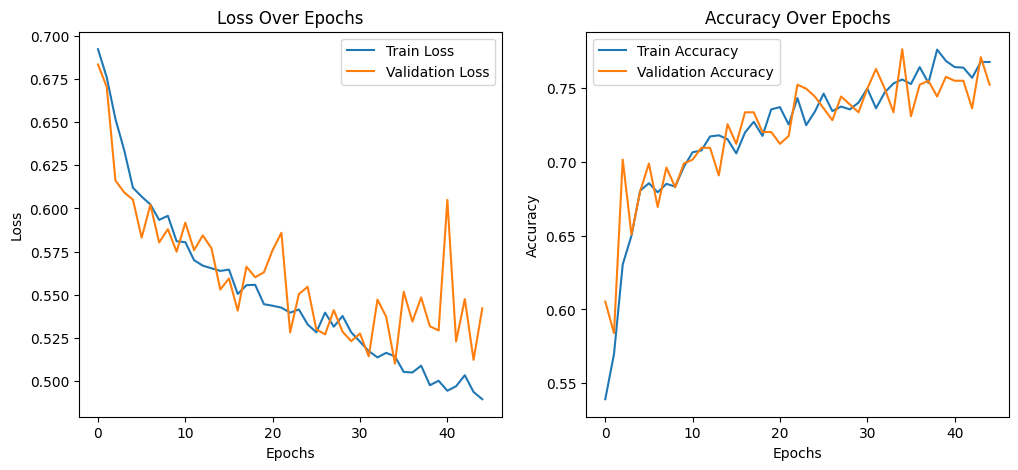

In [14]:
# Vẽ biểu đồ Loss & Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.show()

In [15]:
# Đánh giá trên tập test
test_images_dir = os.path.join(data_dir, "test", "images")
test_annotations_dir = os.path.join(data_dir, "test", "Annotations")
x_test, y_test = load_data(test_images_dir, test_annotations_dir)
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}')


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.7801 - loss: 0.4814
Test accuracy: 0.7744, Test loss: 0.5038


khúc này trở xuống chưa chạy đc

In [16]:
# kiểm tra một ảnh đơn lẻ
# này đang lỗi (chưa nhận diện được khối u)

def predict_single_image(image_path, model):
    # Đọc và xử lý ảnh giống như trong load_data
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (img_h, img_w))
    img = np.array(img, dtype=np.float32) / 255.0
    img = np.expand_dims(img, axis=-1)  # Thêm chiều kênh
    img = np.expand_dims(img, axis=0)  # Thêm batch dimension (1, img_h, img_w, 1)
    
    # Dự đoán
    prediction = model.predict(img)
    
    # Kết quả
    class_idx = np.argmax(prediction)  # Chọn lớp có xác suất cao nhất
    if class_idx == 1:
        print("Ảnh này có khả năng chứa khối u / ung thư.")
    else:
        print("Ảnh này không có khối u / ung thư.")
    
    return prediction

# Chạy thử một ảnh
test_image_path = '/kaggle/input/btxrd-v2/test/images/IMG000005.jpeg'
predict_single_image(test_image_path, model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step
Ảnh này không có khối u / ung thư.


array([[0.5532036, 0.4467964]], dtype=float32)